Have count data (Poisson): <br>
RNAseq (reads per gene), <br>
methylation (2 columns per site: methylated reads, non-metylated reads at site)<br>
<br>
data matrix $X \in \mathbf{R}^{n \times p}$<br>
n rows (samples, strains, tissues, cells)<br>
p columns (genes, isoforms, sites, SNPs)
 
Want to process X, to learn annotatins for rows or columns


### Example
Let rows be cells<br>
Let columns be genes<br>
Let cells be RNAseq read counts<br>
Alternatively Let columns be sites*methStatus (two columns per site) with cells be counts of methylated and unmethylated reads at a site.


Rows may have {sample, strain, tissue} as annotations already.

Can generate new annotations.<br>
(1) Use count data to cluster cells into cell types. Label rows with cell type or cluster number<br>
(2) do other analyses of the X to make annotations for the rows<br>
<br>
Use new annotations in various tests and analyses<br>
(1) Differences across strains of expression of particular genes in particular cell type<br>
(2) Differences across cell types in methylation proportion at particular sites<br>
(3) Differences across strains of position of cell types on UMAP figure<br>

### Problem: information in the data set X is used to define clusters=cell types and to test for the various differences.<br>
Data splitting or replication does not eliminate the problem. If (a) some cells or samples used to define criteria for specifying clusters (b) Then criteria are applied to new cells/samples to label/annote them (cell type) and (c) tests or downstream analyses using labels are done with new cells/samples, the results are still biased, because measurements from the new cells/samples are used to apply the label criteria and to do the tests.

### Solution. 
Unpublished work by Daniela Witten.<br>
Do not split samples/cells. Split reads.<br>

Start with data set X. Cells are read counts.<br>

Make two data arrays with the same dimensions, row labels, column labels, and annotation at $X$: $X_a$, $X_b$<br>

For each cell X[i,j] with count $N_{ij}$<br>
$X_a[i,j] \sim Binomial(\text{size}=N_{ij}, \text{prob}=0.5)$<br>
$X_b[i,j] = N_{ij} - X_a[i,j]$<br>
"For each read, flip a fair coin and put it in $X_a$ if heads or $X_b$ if tails"<br>

### Now
(1) Do whatever you want to $X_a$ to generate new row labels, like cell type or cluster number<br>
(2) Apply new labels to $X_b$<br>
(3) Do whatever tests involving the new labels you want using $X_b$<br>

This is not double dipping. Results are valid.

### Parameterization

Parameterize negative binomial as in paper mean is denoted as $\Lambda$

For $X \sim Poisson(\Lambda)$ <br>
$$
\text{mean}(X) = \text{var}(X) = \Lambda
$$


For $X \sim NB(\Lambda, b)$ <br>

$$
\text{mean}(X) = \Lambda \\
\text{var}(X) = \Lambda + \frac{\Lambda^2}{b} \\
X \sim NB(\Lambda, b)  <=> X \sim {Poisson(\Lambda \cdot \tau) \;\;\;\  \tau \sim Gamma(b,b)}
$$

# Overdispersion Correlation
### overdispersion parameter = $\frac{\Lambda}{b}$

In [1]:
rNB <- function(n, Lambda, b=NA, overdispersion=NA){
    
    if(overdispersion==0){
        x <- rpois(n, lambda=Lambda)
    }else{
    
        if( any(is.na(b))){
            b <- Lambda/overdispersion
        }
    
        x <- rnbinom(n, mu=Lambda, size=b)
    }
    return(x)
}

Illustrate formula 4.15: correlation of values in train and test splits 
by count-splitting in Poisson distributed and in Negative Binomial distributed data. 
Try various overdispersion parameters for Negative Binomial

In [2]:
train.test.correlation <- function(seed=1, n=1000, Lambda=50, overdispersion=0, nreps=1000, verbose=F){
    
    train.test.cor <- rep(as.numeric(NA), nreps)
    
    for(repi in 1:nreps){
        
        X <- rNB(n=n, Lambda=Lambda, overdispersion=overdispersion)
        
        X.train <- X.test <- rep(as.numeric(NA), n)
        for(i in 1:n){
            X.train[i] <- rbinom(1, size=X[i], prob=0.5)
            X.test[i] <- X[i] - X.train[i]
        }
        
        train.test.cor[repi] <- cor(X.train, X.test)
        if(verbose){ print( mean( train.test.cor[1:repi] ) ) }
        
        
        
    }
    
    cor.mean <- mean( train.test.cor)
    cor.se <- sd( train.test.cor )/sqrt(nreps)
    textout <- sprintf("Overdispersion: %f \nCorrelation (Mean): %.4f \nCorrelation (SE): %.4f", 
                       overdispersion, round(cor.mean, 4), round(cor.se,4) )
                      
    cat(textout)
}

In [3]:
train.test.correlation(overdispersion=0, verbose=F ) 

Overdispersion: 0.000000 
Correlation (Mean): 0.0005 
Correlation (SE): 0.0010

In [4]:
train.test.correlation(overdispersion=0.1)

Overdispersion: 0.100000 
Correlation (Mean): 0.0490 
Correlation (SE): 0.0010

In [5]:
train.test.correlation(overdispersion=1)

Overdispersion: 1.000000 
Correlation (Mean): 0.3318 
Correlation (SE): 0.0009

In [6]:
train.test.correlation(overdispersion=10)

Overdispersion: 10.000000 
Correlation (Mean): 0.8335 
Correlation (SE): 0.0003

# Simulation

In [7]:
library(class) ## for knn()
library(Hotelling) ## for hotelling.test()

Warning message:
“package ‘class’ was built under R version 4.1.2”
Loading required package: corpcor



In [8]:
c(-2 : 2)

[1] -2 -1  0  1  2

In [9]:
## n = number of cells
## p = number of genes, features
## Nct = number of cell types
## meanCountDist = baseline distribtuion of counts per (cell-gene)
## cellTypeEffects = distribtuion of cell-type specific offsets in mean count per gene
## countThreshold = minimum count per cell-gene
## randOffsetSD = sd of random noise in count means

generateCountData <- function(seed, n=1000, p=1000,
                              Nct=4, meanCountDist=c(10:80),
                              cellTypeEffects=c(-2:2),
                              countThreshold=5, randOffsetSD=1){
                              
    set.seed(seed)

    ## mean count per gene=column
    meanCounts <- sample(x=meanCountDist, size=p, replace=T)

    
    ## cell-type specific offset of mean count at each gene
    cellTypeOffsets <- matrix(sample(cellTypeEffects, Nct*p, replace=T),
                              nrow=Nct, ncol=p)
     
    ## noise in cell-type by gene mean count matrix
    randOffset <- matrix(rnorm(n*p, sd=randOffsetSD),n,p)
    
    ## row annotation (cell type, cluster ID, ...)
    rAnnotation <- data.frame( cellType=sample(c(1:Nct), size=n, replace=T) )
    
    ## data matrix: n(cells) -by- p(genes, features)
    X <- matrix(as.numeric(NA), n, p)
    
    ## draw read counts for each row 1:n
    for(i in 1:n){
        cellType <- rAnnotation[i,1]
        col.means <- meanCounts + cellTypeOffsets[cellType,] + randOffset[i,] 
            
        col.means[col.means < countThreshold] <- countThreshold
        col.counts <- rpois(n=p, lambda=col.means) ## n here is number of draws from rpois = rowlength = p
        X[i,] <- col.counts
    }
    ret <- list(X=X, rAnnotation=rAnnotation)
    return(ret)
}

In [10]:
generateCountData.test <- function(seed=1,n=1000, p=1000, 
                                   Nct=4, meanCountDist=c(10:80),
                                   cellTypeEffects=c(-2:2),
                                   countThreshold=5, randOffsetSD=1,
                                   nplots=2){
   
    gen <- generateCountData(seed=1,
                             n=n, p=p, Nct=Nct,
                             cellTypeEffects=runif(100, min=-2,max=2),
                             countThreshold=countThreshold, randOffsetSD=randOffsetSD)
    X <- gen$X
    
    if(nplots>=1){
        udv <- svd(scale(X), nu=3, nv=3)
        ## print(head(udv$d))
        plot(x=udv$u[,1], y=udv$u[,2], col=gen$rAnnotation$cellType, pch=20,
             xlab="PC1", ylab="PC2", main="Color by true cell type")
    }
    if(nplots==2){
        plot(x=udv$u[,2], y=udv$u[,3], col=gen$rAnnotation$cellType, pch=20,
             xlab="PC2", ylab="PC3", main="Color by true cell type")
    }

}

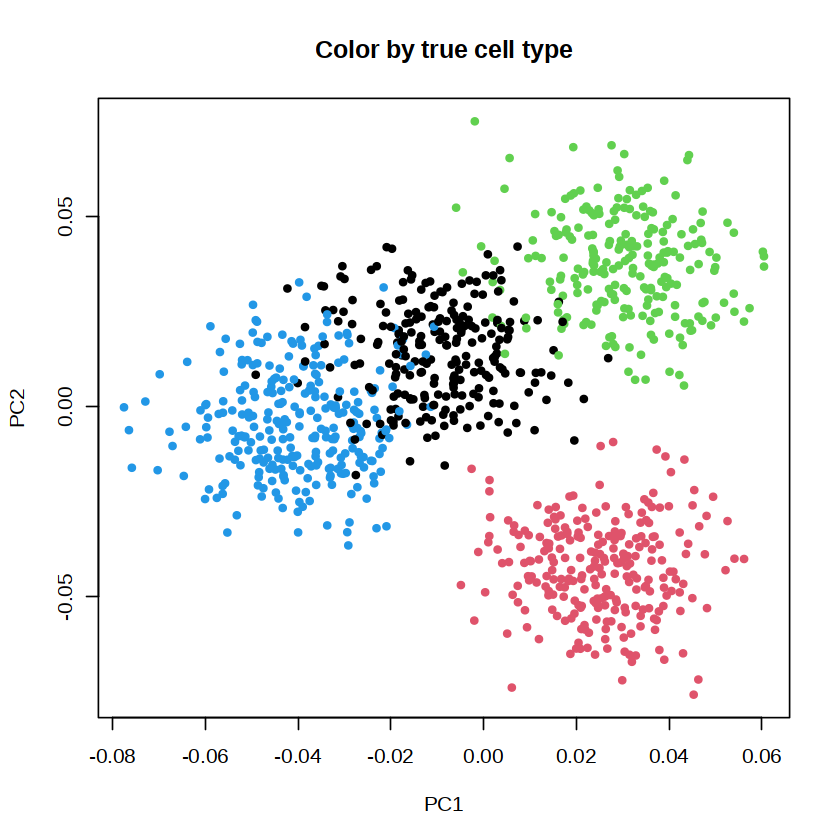

In [11]:
## short name
gcdt <- generateCountData.test
gcdt(Nct=4, randOffsetSD=5, nplots = 1)

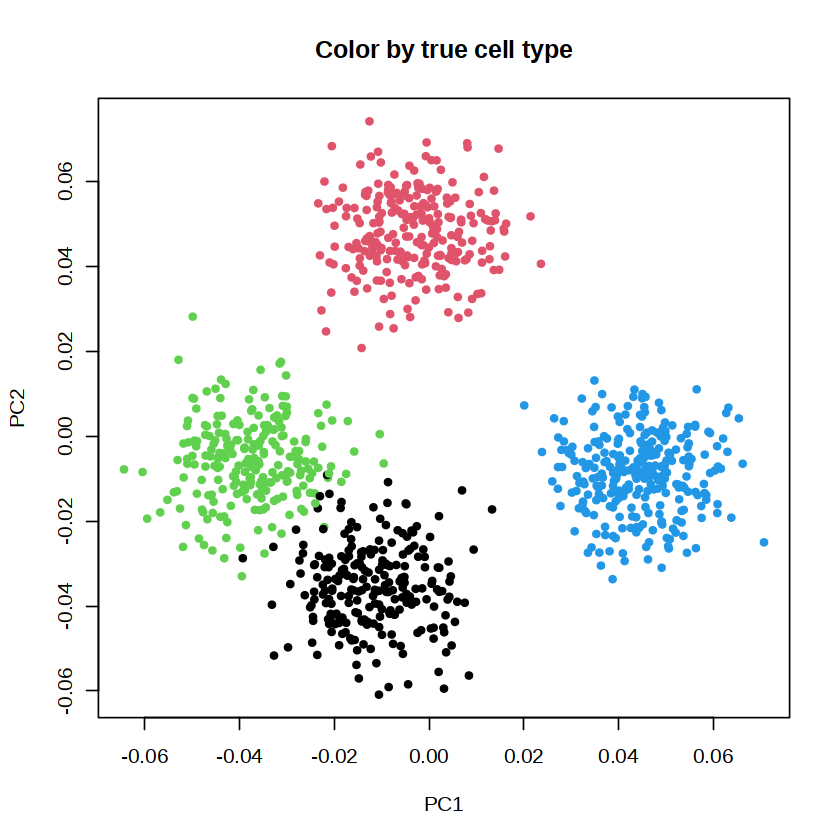

In [12]:
# a more distict 4 celltypes with stronger cellTypeEffects and smaller noise randOffsetSD
gcdt(Nct=4, randOffsetSD=1, cellTypeEffects=c(-5:5), nplots = 1)

In [13]:
## split X so half rows in X1 and other half in X2
dataSplit <- function(dat, seed=1){
    X <- dat$X
    rAnnotation <- dat$rAnnotation
    set.seed(seed)
    n <- nrow(X)
    n1 <- ceiling(n/2)
    n2 <- n-n1
    ind1 <- sample(1:n, size=n1, replace=F)
    ind2 <- setdiff(1:n,ind1)
    X1 <- X[ind1,]
    X2 <- X[ind2,]
    rAnnotation.split1 <- rAnnotation[ind1,]
    rAnnotation.split2 <- rAnnotation[ind2,]
    ret <- list(X1=X1, X2=X2, ind1=ind1, ind2=ind2,
                rAnnotation.split1=rAnnotation.split1,
                rAnnotation.split2=rAnnotation.split2)
    return(ret)
}

## split X into two matrices of same size.  
## foreach read in each cell, flip a fair coin
## if heads, put count in Xa, else in Xb
## For each cell X[i,j] with count Nij
## Xa[i,j] ~ Binomial(size=Nij, prob=0.5)
## Xb[i,j] = Nij - Xa[i,j]
poissonThinning <- function(dat,seed=1){
    X <- dat$X
    set.seed(seed)
    n <- nrow(X)
    m <- ncol(X)
    Xa <- Xb <- matrix(rep(as.numeric(NA),n*m),n,m)
    for( i in 1:n ){
        for( j in 1:m ){
            Nij <- X[i,j]
            Xa[i,j] <- rbinom(1, size=Nij, prob=0.5)
            Xb[i,j] <- Nij - Xa[i,j]
        }
    }
    ret <- list(Xa=Xa, Xb=Xb)
    return(ret)
}

##  doClustering(data, k): 
##  input data matrix "data", and number of clusters to find "k"
##  uses kmeans to cluster rows
##  return vector of row labels = cluster numbers
##  
##  uses
##  R library(class):
##      kmeans(x, centers, iter.max = 10, nstart = 1,
##            algorithm = c("Hartigan-Wong", "Lloyd", "Forgy",
##                          "MacQueen"), trace=FALSE)
doClustering <- function(data, k){
    clusterIDs <- as.integer(kmeans(data,k)$cluster)
    return(clusterIDs)
}

## doClassification(train, test, train.lab, k=1)
## input data matrices train and test with count data for same columns (genes, features)
## rows of "train" matrix have cluster IDs (integers) in input vector train.lab
## use k-nearest neighbors to assign to the rows of "test" matrix
## each row in "test" to neighbors in "train"
## input "k" for knn
## output: vector of integers = row labels for "test" matrix = cluster IDS
doClassification <- function(train, test, train.lab, k=1){
    require(class)
    test.clust <- as.integer(knn(train=train, test=test, cl=train.lab, k = k))
    return(test.clust)
}

In [14]:
## given matrix of count data: n rows (cells, observation units), p columns (genes, features)
## simulate count data with "Nct" (number of cell types) distinct clusters among the rows
## Analyze the data using a clustering method that finds (forces) "Nclust" different clusters to be detected
## For Nct>1, there will be cell-type or cluster specific offsets to the mean counts at each gene=feature
## extra noise in the data matrix (mean count at cell-by-gene) with specified SD = randOffsetSD
## compare splitting cells into train-test splits vs count splitting of entire data matrix

compareTests <- function(seed=1, n=1000, p=50,
                         Nct=2, Nclust=2,
                         cellTypeEffects=NA,  
                         randOffsetSD=1){

    set.seed(seed)
    if(all(is.na(cellTypeEffects))){
        cellTypeEffects <- runif(100, min=-5,max=5)
    }
    
    dat <- generateCountData(seed=seed, n=n, p=p, Nct=Nct,
                             cellTypeEffects=cellTypeEffects, randOffsetSD=randOffsetSD)
  
    udv <- svd(scale(dat$X), 10,10) ## PCs based on whole data set
    plot(x=udv$u[,1], y=udv$u[,2], col=dat$rAnnotation$cellType, pch=20,
         xlab="PC1", ylab="PC2", main="Color by true cell type")
    
    
    ## split cells into train and test sets
    ## find cell types (clusters) by kmeans in training set
    ## assign cluster labels to test set using cluser model,
    ##        cell types, from training set
    dat.split <- dataSplit(dat, seed=seed)
    dat.split.clust <- doClustering(data=dat.split$X1, k=Nclust)
    dat.split.classify <- doClassification(train=dat.split$X1,
                                           test=dat.split$X2,
                                           train.lab=dat.split.clust,
                                           k=Nclust)
    
    
    udv.split.1 <- svd(scale(dat.split$X1),10,10) ## train-test cell-split training set
    pcs1 <- scale(dat$X) %*% udv.split.1$v  ## PCs based on cell-split training set
    
    udv.split.2 <- svd(scale(dat.split$X2),10,10) ## train-test cell-split testing set
    pcs2 <- scale(dat$X) %*% udv.split.2$v  ## PCs based on cell-split testing set
    
     
    ## training split
    rant1 <- dat.split$rAnnotation.split1
    pcs.train <- as.data.frame(pcs1[dat.split$ind1,])## PCs for cell-split training data
    names(pcs.train) <- paste("pc", 1:(ncol(pcs.train)), sep="")
    res.split.train <- data.frame(trueClust=rant1, classifier=dat.split.clust, pcs.train)
    
    ## test split
    rant2 <- dat.split$rAnnotation.split2 ## true cluster information for cell-split test set
    pcs.test <- as.data.frame(pcs1[dat.split$ind2,]) ## PCs for cell-split test data
    names(pcs.test) <- paste("pc", 1:(ncol(pcs.test)), sep="")
    res.split.test <- data.frame(trueClust=rant2, classifier=dat.split.classify, pcs.test)
    
    plot(pc2~pc1, pch=20, col=dat.split.clust, data=res.split.train,
         main="Assigned clusters by train-test split of cells\n training set")
    
    plot(pc2~pc1, pch=20, col=dat.split.classify, data=res.split.test,
         main="Assigned clusters by train-test split of cells\n test set")
    
    ## Hotelling T-test for multivariate distance between cluster1 and cluster2 from
    ## classification. 
    ## use coordinates from first three PCs
    
    ## hot.split <- hotelling.test(x=udv.split.2$u[dat.split.classify==1,1:2],
    ##                             y=udv.split.2$u[dat.split.classify==2,1:2])
    x <- pcs1[dat.split$ind2,][dat.split.classify==1,1:3] ## pcs of test data in cluster 1
    y <- pcs1[dat.split$ind2,][dat.split.classify==2,1:3] ## pcs of test data in cluster 2
    hot.split <- hotelling.test(x=x, y=y)
    
    hot.split.string <- sprintf("Hotelling test for train-test split analysis\n test-statistic: %f.1\n degrees of freedom: %d %d\n p-value: %f\n",
                                hot.split$stats$statistic, hot.split$stats$df[1], 
                                hot.split$stats$df[2], hot.split$pval)
    cat(hot.split.string)
    
    ###### count splitting analysis
    
    dat.thin <- poissonThinning(dat, seed=seed)
    dat.thin.clust <- doClustering(data=as.matrix(scale(dat.thin$Xa)), k=Nclust)
    dat.thin.classify <- dat.thin.clust ## lift over row labels

    
    udv.thin.a <- svd(scale(dat.thin$Xa),10,10)  ## count splitting training set
    udv.thin.b <- svd(scale(dat.thin$Xb),10,10)  ## count splitting test set

    
    hot.thin <- hotelling.test(x=udv.thin.b$u[dat.thin.classify==1,1:3],
                               y=udv.thin.b$u[dat.thin.classify==2,1:3])

    hot.thin.string <- sprintf("Hotelling test for count-splitting analysis\n test-statistic: %f.1\n degrees of freedom: %d %d\n p-value: %f\n",
                                hot.thin$stats$statistic, hot.thin$stats$df[1], 
                                hot.thin$stats$df[2], hot.thin$pval)
   
    pc.thin.train <- as.data.frame(udv.thin.a$u)
    pc.thin.test <- as.data.frame(udv.thin.b$u)
    
    names(pc.thin.train) <- paste("pc", 1:(ncol(pc.thin.train)), sep="")
    names(pc.thin.test) <- paste("pc", 1:(ncol(pc.thin.test)), sep="")
    ## browser()
    plot(pc2~pc1, pch=20, col=dat.thin.clust, data=pc.thin.train,
         main="Assigned clusters by count-splitting \n training set")
    
    plot(pc2~pc1, pch=20, col=dat.thin.classify, data=pc.thin.test,
         main="Assigned clusters by count-splitting \n test set")
    cat(hot.thin.string)
     
}

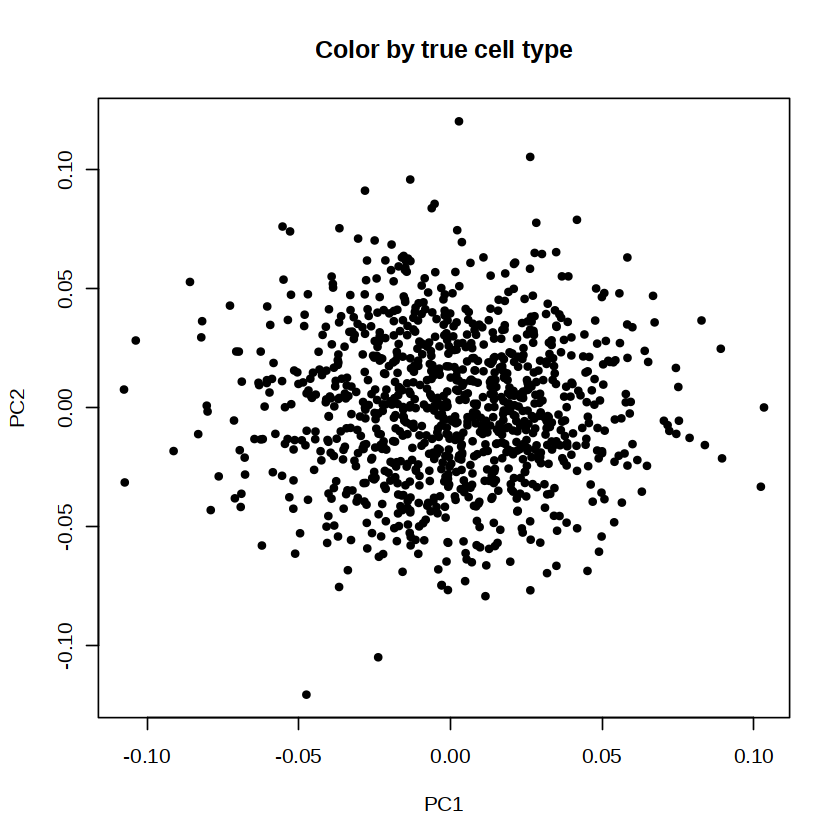

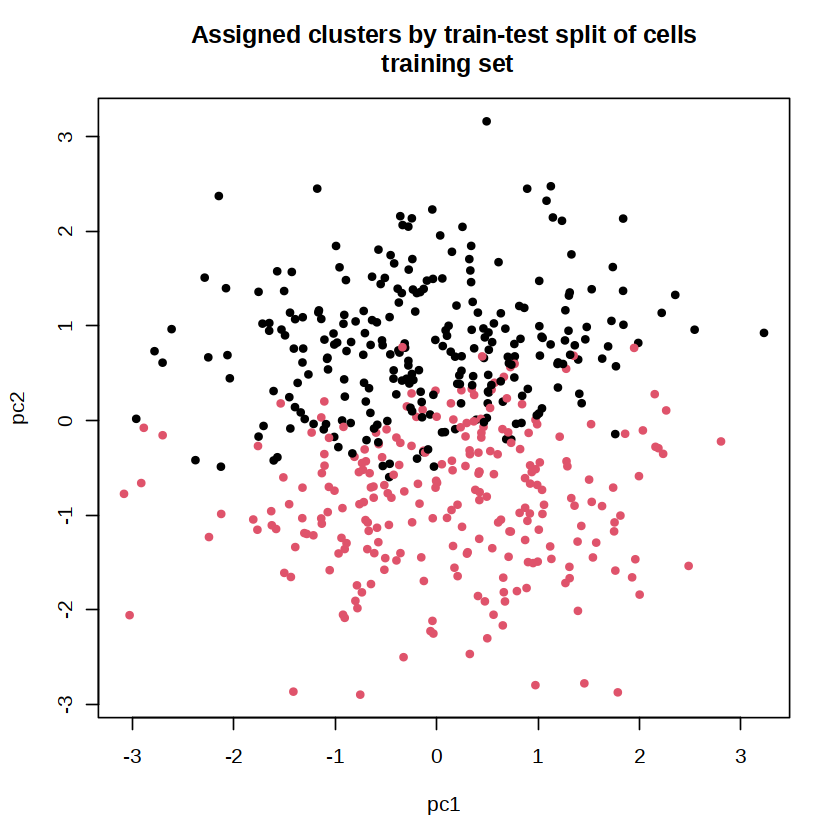

Hotelling test for train-test split analysis
 test-statistic: 332.535170.1
 degrees of freedom: 3 496
 p-value: 0.000000


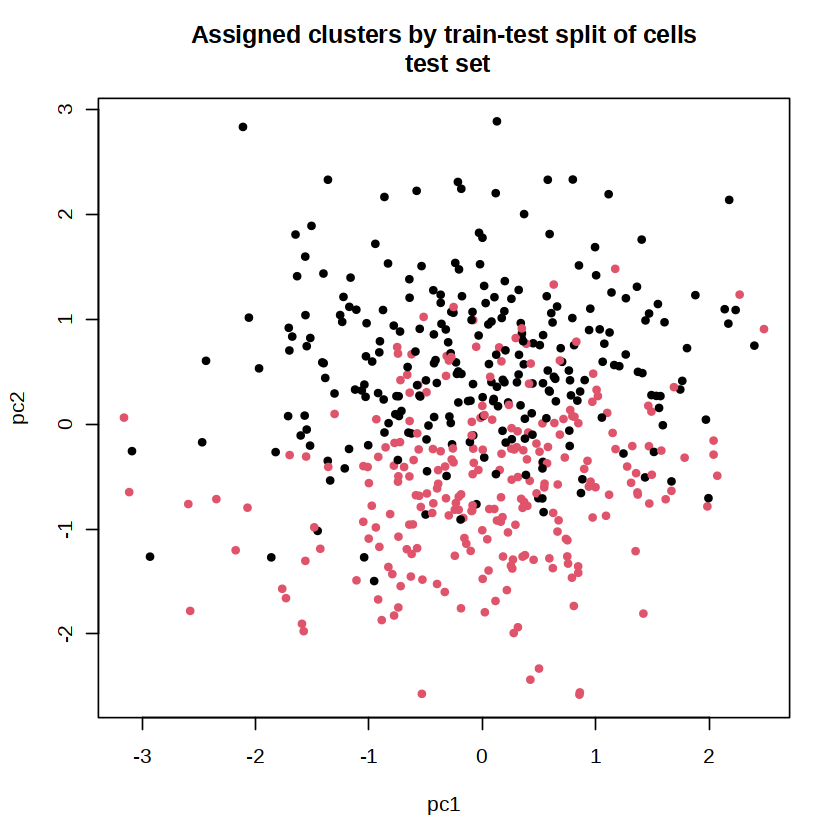

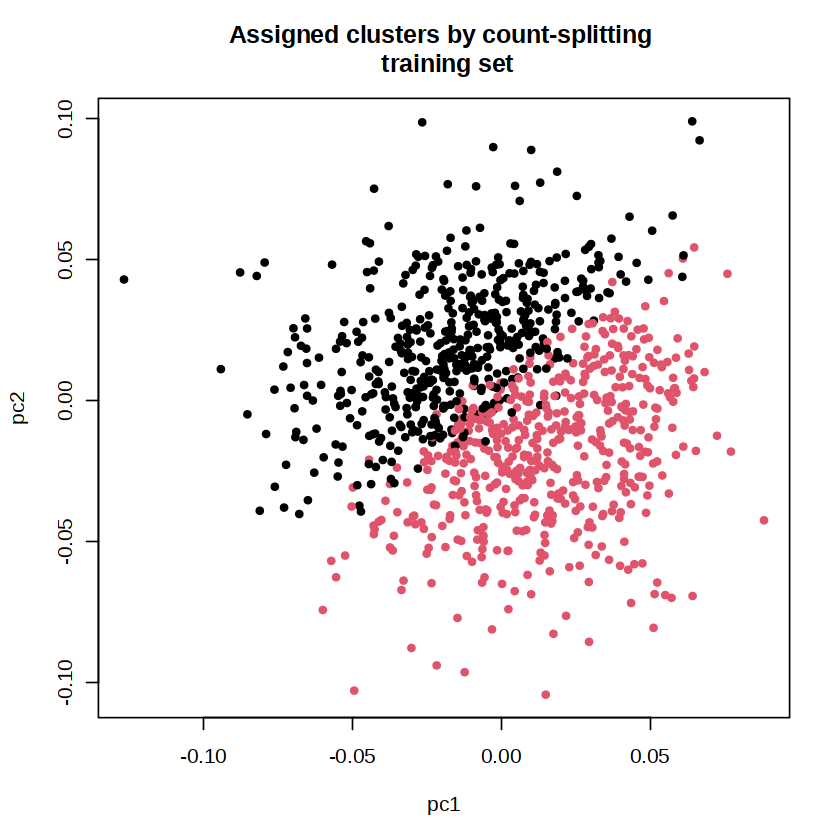

Hotelling test for count-splitting analysis
 test-statistic: 0.293298.1
 degrees of freedom: 3 996
 p-value: 0.961374


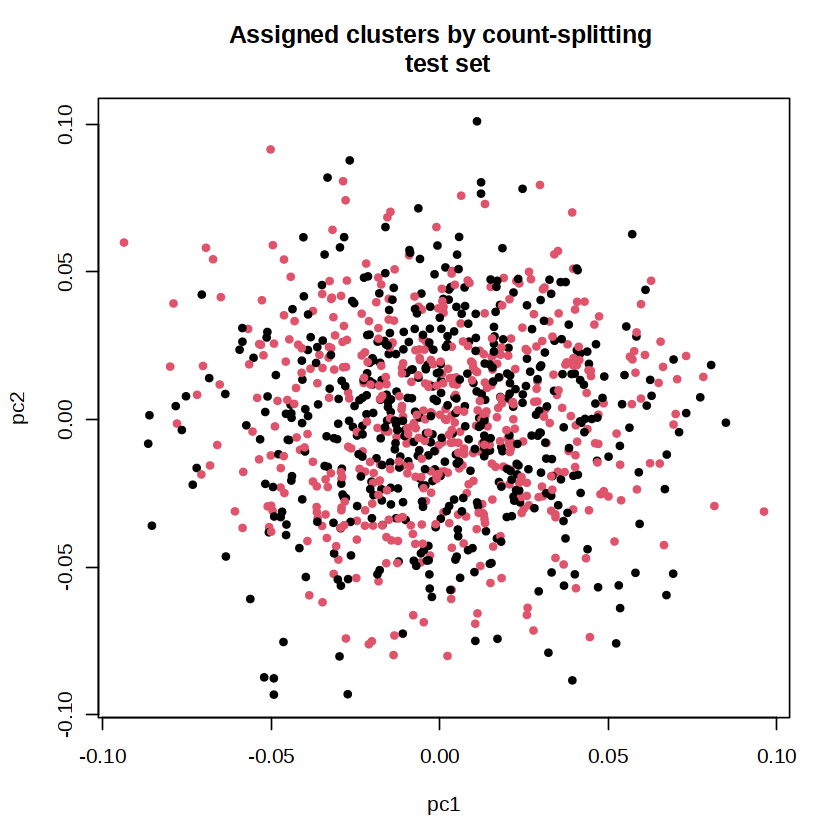

In [15]:
compareTests(Nct=1, Nclust=2, seed=1, p=10)

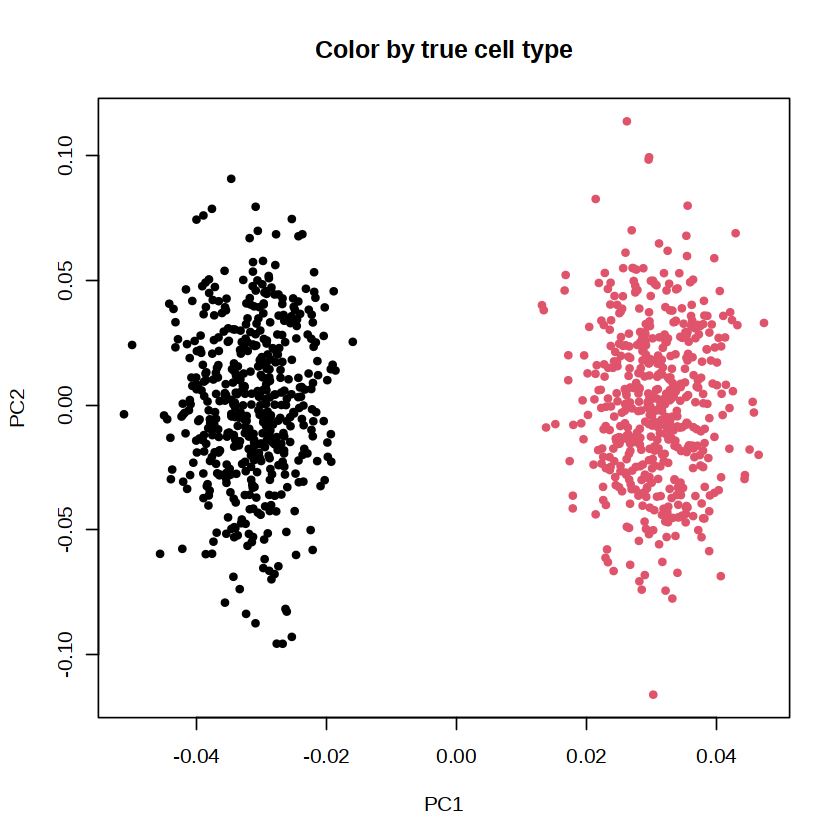

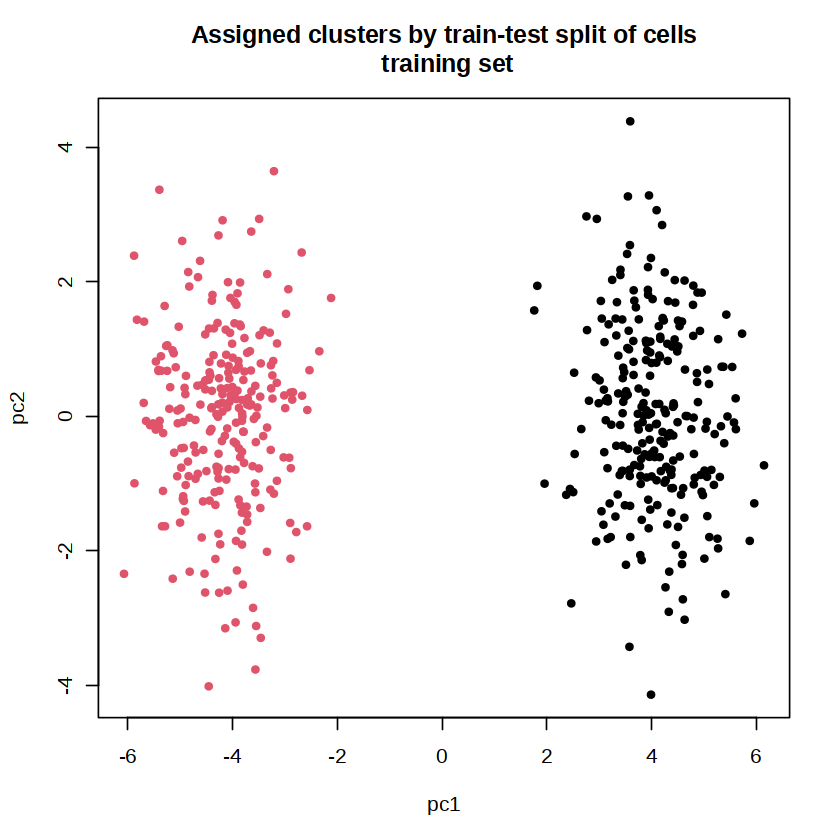

Hotelling test for train-test split analysis
 test-statistic: 14410.688070.1
 degrees of freedom: 3 496
 p-value: 0.000000


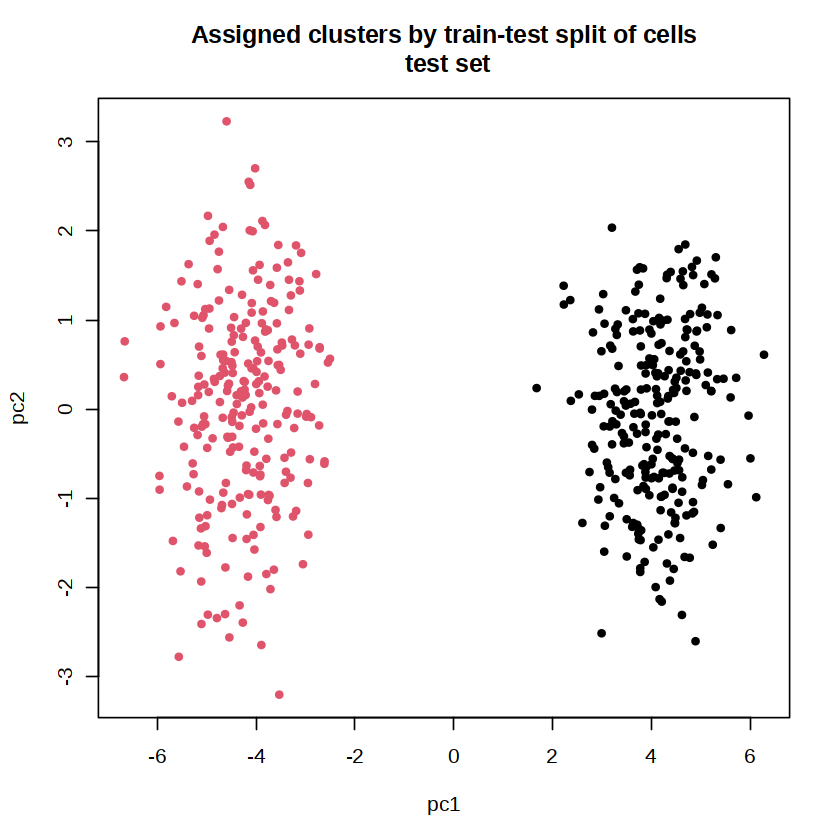

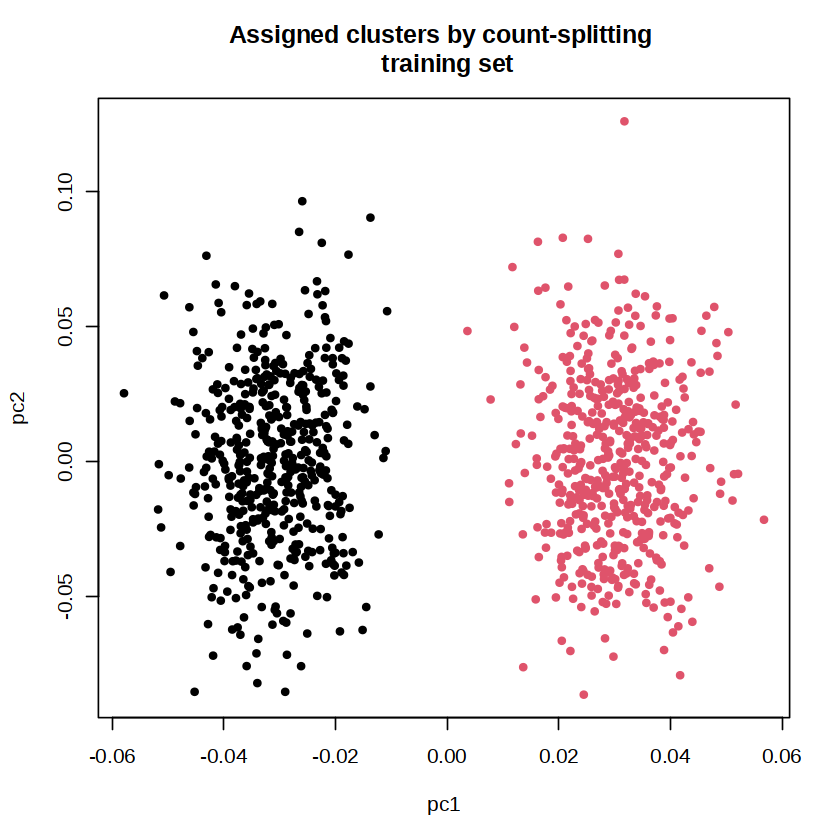

Hotelling test for count-splitting analysis
 test-statistic: 14191.264161.1
 degrees of freedom: 3 996
 p-value: 0.000000


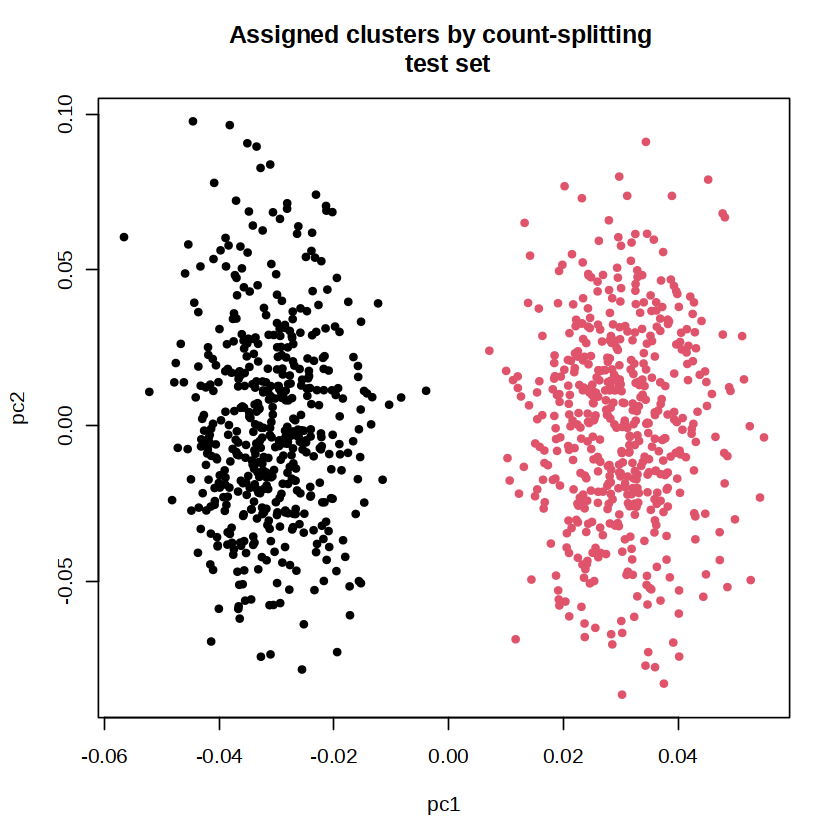

In [16]:
compareTests(Nct=2, Nclust=2, seed=1, p=100, cellTypeEffects=c(-5,5), randOffsetSD=1)